In [330]:
!pip install scikeras

In [331]:
import tensorflow as tf

In [332]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier

In [333]:
data=pd.read_csv('/content/data_email_campaign.csv')

In [334]:
data

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
68348,EMA00089995974500,2,0.4,1,F,2,22.0,3,737,16.0,13.0,0
68349,EMA00089998225300,1,1.3,1,C,2,40.0,2,653,31.0,16.0,0
68350,EMA00089998436500,1,2.2,2,NaN,2,33.0,2,490,9.0,0.0,0
68351,EMA00089999168800,1,0.4,1,E,2,50.0,1,733,14.0,4.0,0


In [335]:
data = data.dropna()

In [336]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48291 entries, 0 to 68352
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Email_ID                   48291 non-null  object 
 1   Email_Type                 48291 non-null  int64  
 2   Subject_Hotness_Score      48291 non-null  float64
 3   Email_Source_Type          48291 non-null  int64  
 4   Customer_Location          48291 non-null  object 
 5   Email_Campaign_Type        48291 non-null  int64  
 6   Total_Past_Communications  48291 non-null  float64
 7   Time_Email_sent_Category   48291 non-null  int64  
 8   Word_Count                 48291 non-null  int64  
 9   Total_Links                48291 non-null  float64
 10  Total_Images               48291 non-null  float64
 11  Email_Status               48291 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 4.8+ MB


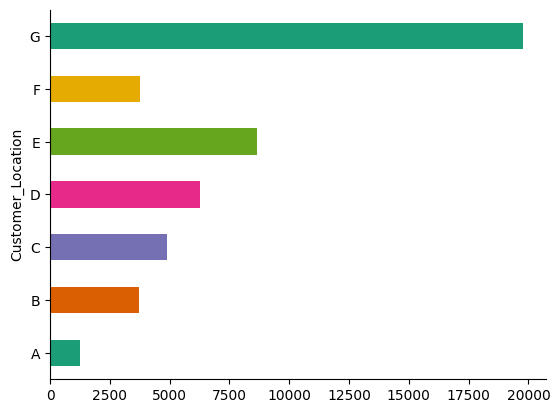

In [10]:
# @title Customer_Location

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Customer_Location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

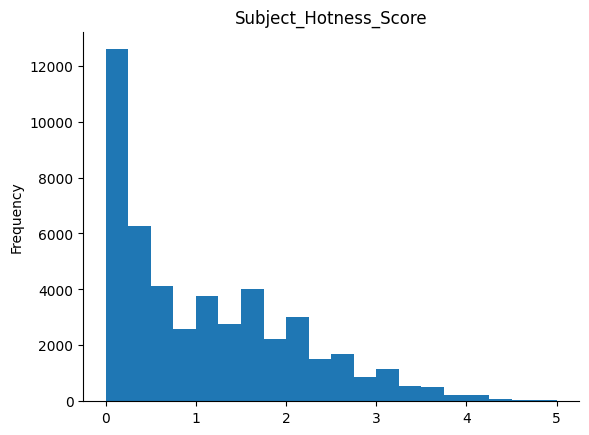

In [11]:
# @title Subject_Hotness_Score

from matplotlib import pyplot as plt
data['Subject_Hotness_Score'].plot(kind='hist', bins=20, title='Subject_Hotness_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [337]:
X = data.drop(columns=['Email_ID', 'Email_Status'])
y = data['Email_Status']

In [338]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [339]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

In [340]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [341]:
categorical_features = X.select_dtypes(include=['object']).columns

In [342]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [343]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [344]:
# Create a Sequential model
FF_model = Sequential()

# Add multiple Dense layers with different number of units and activation functions
FF_model.add(Dense(128, input_dim=10, activation='relu'))
FF_model.add(Dense(86, activation='relu'))
FF_model.add(Dense(64, activation='relu')) # First hidden layer with 64 units
FF_model.add(Dense(32, activation='relu'))  # Second hidden layer with 32 units
FF_model.add(Dense(16, activation='relu'))  # Third hidden layer with 16 units

# Output layer with one unit and sigmoid activation function for binary classification
FF_model.add(Dense(1, activation='sigmoid'))

# Compile the model
FF_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [345]:
FF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', FF_model)
])

In [346]:
FF.fit(X_train, y_train)

1208/1208 [==============================] - 12s 5ms/step - loss: 0.3936 - accuracy: 0.7934


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Email_Type', 'Subject_Hotness_Score', 'Email_Source_Type',
       'Email_Campaign_Type', 'Total_Past_Communications',
       'Time_Email_sent_Category', 'Word_Count', 'Total_Links',
       'Total_Images'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Customer_Location'], dtype='object'))])),
                ('feature_selection', SelectKBest()),
                ('classifier',
                 <keras.src.engine.sequential.Sequential object at 0x7a23d1140e50>)])

In [349]:
y_pred_FF = FF.predict(X_test)

302/302 [==============================] - 1s 3ms/step


In [350]:
y_pred_DL=y_pred_FF.round(0)

In [351]:
accuracy_FF = accuracy_score(y_test, y_pred_DL)
print("Accuracy_FF:", accuracy_FF)

Accuracy_FF: 0.8063981778652034


In [352]:
RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier())
])

In [353]:
RF.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Email_Type', 'Subject_Hotness_Score', 'Email_Source_Type',
       'Email_Campaign_Type', 'Total_Past_Communications',
       'Time_Email_sent_Category', 'Word_Count', 'Total_Links',
       'Total_Images'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Customer_Location'], dtype='object'))])),
                ('feature_selection', SelectKBest()),
                ('classifier', RandomForestClassifier())])

In [354]:
y_pred_RF=RF.predict(X_test)

In [355]:
accuracy_RF = accuracy_score(y_test, y_pred_RF)
print("Accuracy_DL:", accuracy_RF)

Accuracy_DL: 0.8038099182109949
